In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
import matplotlib.font_manager as fm
import matplotlib.colors as mcolors
from matplotlib import cm
from highlight_text import fig_text

from PIL import Image
import urllib
import os
import math

In [3]:
plt.style.use('./assets/stylesheets/soc_base.mplstyle')

In [6]:
df = pd.read_csv('data/league_one_xg_xgot.csv',index_col=0)

df_h = (
    df[['home_team_'+x for x in ['name','id','score','xG']]]
    .rename(
        columns={
            'home_team_name':'team_name',
            'home_team_id':'team_id',
            'home_team_score':'score',
            'home_team_xG':'xG',
        }
    )
)

df_a = (
    df[['away_team_'+x for x in ['name','id','score','xG']]]
    .rename(
        columns={
            'away_team_name':'team_name',
            'away_team_id':'team_id',
            'away_team_score':'score',
            'away_team_xG':'xG',
        }
    )
)

data = pd.concat([df_h,df_a]).reset_index(drop=True)
data = data.groupby(['team_name','team_id']).sum().reset_index()
data = data.assign(difference =data['score'] - data['xG'])
data = data.sort_values(by = 'difference').reset_index(drop=True)

In [ ]:
gradient = [
    '#de6f57',
    '#d5724d',
    '#cb7644',
    '#c0783e',
    '#b57b38',
    '#a97d35',
    '#9e7f34',
    '#928134',
    '#878137',
    '#7c823a',
    '#71823f',
    '#668244',
    '#5c814a',
    '#528050',
    '#497f56',
    '#407d5b',
    '#387b61',
    '#317966',
    '#2c776a',
    '#29756e',
    '#287271',
]
soc_cm = mcolors.LinearSegmentedColormap.from_list('SOC', gradient, N=50)
cm.register_cmap(name='SOC', cmap=soc_cm)

<BarContainer object of 24 artists>

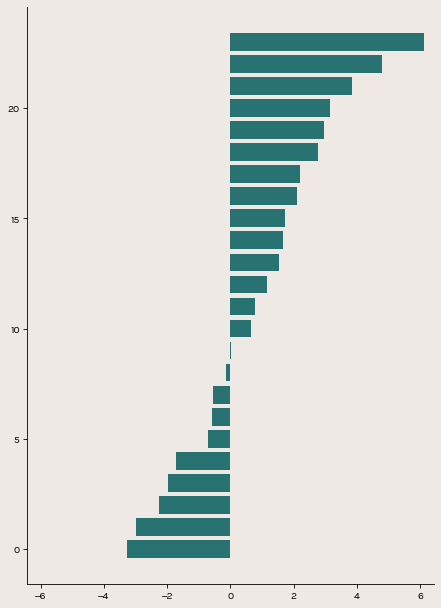

In [7]:
fig = plt.figure(figsize=(7,10), dpi=75)
ax = plt.subplot()
max_ = max(abs(data['difference'].min()),data['difference'].max())

max_ = max_*1.05
ax.set_xlim(-max_,max_)

ax.barh(data.index, data['difference'])